In [44]:
import numpy as np
import scipy as sp
import pickle
import utilities as u
import preprocessing as pp
import SimulatedSimMats as ssm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import UnityTransforms as ut

In [45]:
with open("D:\\Morph_Results\\rare_sf_regression.pkl",'rb') as f:
    rare_sfreg = pickle.load(f)
    
with open("D:\\Morph_Results\\freq_sf_regression.pkl",'rb') as f:
    freq_sfreg = pickle.load(f)

In [46]:
print(rare_sfreg.keys())

dict_keys(['4139265.3', '4139265.4', '4139265.5', '4222168.1', '4343703.1', '4343706'])


In [48]:
def mean_prior_post(dict_sfreg,sigma_likelihood=.3,x=np.linspace(-.1,1.1,num=1000)[np.newaxis,:]):
    mice = [mouse for mouse in dict_sfreg.keys()]
    priors = np.zeros([len(mice),x.shape[1]])
    for i, (mouse,res) in enumerate(dict_sfreg.items()):
        _prior=None
        for _p in res['priors']:
            if _prior is None:
                _prior = _p
            else:
                _prior+=_p
        _prior = _prior/_prior.sum()
        priors[i,:]=_prior
        
    prior = _prior.mean(axis=0,keepdims=True)
    prior = prior/prior.sum()
    post = prior*u.gaussian(np.linspace(-.3,1.3,num=1000)[:,np.newaxis],sigma_likelihood,np.linspace(-.3,1.3,num=1000)[np.newaxis,:])
    post = post/post.sum(axis=1)
    return priors, prior, post
rare_priors,rare_prior,rare_post = mean_prior_post(rare_sfreg)
freq_priors,freq_prior,freq_post = mean_prior_post(freq_sfreg)
xx = np.linspace(-.3,1.3,num=1000)[np.newaxis,:]
rare_spline = ssm.make_sampling_spline(xx.ravel(),rare_prior)
freq_spline = ssm.make_sampling_spline(xx.ravel(),freq_prior)


In [7]:
def single_cell_model(log_cumprior_spline,d):
    '''
    implement hebbian learning for a single cell with inputs that are RBFs for some stimulus
    inputs: log_cumprior_spline - numpy univariate spline for sampling from the cumulative prior
            d - dictionary of parameters
    returns: w - weights of learned model
            yy - activity of cell
    '''
    
    ### INITIALIZATIONS
    THETA = np.linspace(-.3,1.3,num=d['nInputs']) 
    if d['alpha'] is None:
        d['alpha']=1/d['nInputs']
        
        
    w = np.random.rand(d['nInputs']) # uniformly distributed random small weights
    
   
    samples = log_cumprior_spline(np.random.rand(d['nSamples'])) # sample from prior
    ### LEARNING
    for i,s in enumerate(samples.tolist()):
        # generate inputs from those samples
#         x =u.gaussian(THETA,d['sigma'],s+d['stim noise']*np.random.randn(1)) 
        x =np.random.poisson(u.gaussian(THETA,d['sigma'],s)) #+d['stim noise']*np.random.randn(1)) 
#         y=np.maximum(d['alpha']*np.dot(w,x) + d['act noise']*np.random.randn(1),0) # rectified activation of cell
        y = np.random.poisson(d['alpha']*np.dot(w,x))
        # update weights
        dw = d['eta']*x*y - d['tau'] #+ d['dW noise']*np.random.randn(w.shape[0])
        w+=dw 
        w=np.maximum(np.minimum(w,d['Wmax']),0) # rectify and clamp range of weights
        

    ### SAMPLE FROM LEARNED MODEL
    morph_theta = np.linspace(-.3,1.3,num=1000) # morph values to sample at
    yy = np.zeros(morph_theta.shape) # output 
    for i,s in enumerate(morph_theta.tolist()):
        # inputs
        x =u.gaussian(THETA,d['sigma'],s+d['stim noise']*np.random.randn(1)) 
        yy[i]=np.maximum(d['alpha']*np.dot(w,x) + d['act noise']*np.random.randn(1),0) # rectified activation of cell
    
    return w,yy,morph_theta,samples


Text(0.5, 1.0, 'Frequent morph prior')

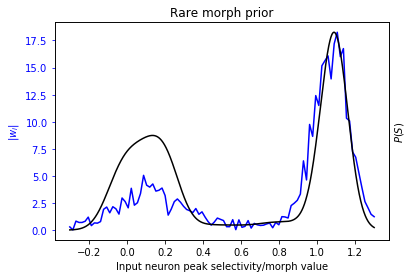

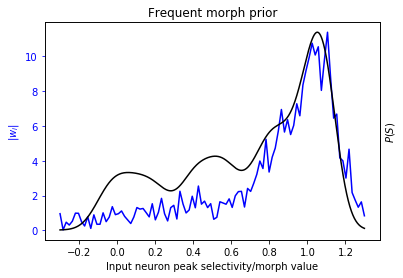

In [8]:
d_singlecell = {'stim noise': .05, # constant for sampling from standard Gaussian noise
    'nInputs': 100, # number of input neurons
    'nSamples':1000, # num training samples
    'alpha':.01, # constant to apply to output, defaults to 1/nInputs
    'eta': .1, # learning rate, results are somewhat sensitive to this value
    'sigma': .1, # width of radial basis functions
    'act noise':.0, # noise to apply to output
    'dW noise': 0.00, # constant to apply to weight update noise 
    'tau': .0000, # forgetting rate
    'Wmax':np.inf } # maximum value of weight

# rare morph prior
w,y,morph_theta,samples = single_cell_model(rare_spline,d_singlecell)

f,ax = plt.subplots()

ax.plot(np.linspace(-.3,1.3,num=w.shape[0]),w,color='blue')
ax.set_ylabel('$\|w_i\|$')
ax.yaxis.label.set_color('blue')
ax.tick_params(axis='y', colors='blue')
ax_dense = ax.twinx()
ax_dense.plot(np.linspace(-.3,1.3,num=rare_prior.shape[1]),rare_prior.ravel(),color='black',label='Prior Density')
ax_dense.set_ylabel('$P(S)$')
ax_dense.set_yticks([])
ax.set_xlabel('Input neuron peak selectivity/morph value')
ax.set_title("Rare morph prior")
# f.savefig("G:\\My Drive\\CNJC_2020\\single_cell_rare.pdf",format='pdf')



# frequent morph prior
w,y,morph_theta,samples = single_cell_model(freq_spline,d_singlecell)

f,ax = plt.subplots()
ax.plot(np.linspace(-.3,1.3,num=w.shape[0]),w,color='blue')
ax.set_ylabel('$\|w_i\|$')
ax.yaxis.label.set_color('blue')
ax.tick_params(axis='y', colors='blue')
ax_dense = ax.twinx()
ax_dense.plot(np.linspace(-.3,1.3,num=freq_prior.shape[1]),freq_prior.ravel(),color='black',label='Prior Density')
ax_dense.set_ylabel('$P(S)$')
ax_dense.set_yticks([])
ax.set_xlabel('Input neuron peak selectivity/morph value')
ax.set_title("Frequent morph prior")

# f.savefig("G:\\My Drive\\CNJC_2020\\single_cell_freq.pdf",format='pdf')


In [9]:
def kwta_network_model(log_cumprior_spline, d):
    
    ## INITIALIZATIONS
    THETA = np.linspace(-.1,1.1,num=d['nInputs']) 
    if d['alpha'] is None:
        d['alpha']=1/d['nInputs']
    W = .1*np.random.rand(d['nInputs'],d['n_neurons']) # weight matrix
    k = int(d['n_neurons']*d['wta_k']) # number of winners
    
    
    #draw samples for learning
    samples = log_cumprior_spline(np.random.rand(d['nSamples']))
    
    
    ## LEARNING
    for i,s in enumerate(samples.tolist()):
        # inputs
        x =u.gaussian(THETA,d['sigma'],s+d['stim noise']*np.random.randn(1)) 
#         x = np.random.gamma(u.gaussian(THETA,d['sigma'],s))
        # activation of each cell
        act = np.matmul(W.T,x)+ d['act noise']*np.random.randn(d['n_neurons'])
        sort = np.argsort(act) # sort to find K winners
        # determine output for K winners
        Y = np.zeros(act.shape)
        Y[sort[-1:-k-1:-1]]=d['alpha']*act[sort[-1:-k-1:-1]] 
        Y[sort[-k:0:-1]]=d['act noise']*act[sort[-k-1]]*np.random.randn(100-k)
        Y = np.maximum(Y,0) # make sure noise doesn't push the value negative
        
        # update weights
        dw = d['eta']*x[:,np.newaxis]*Y[np.newaxis,:] + d['dW noise']*np.random.randn(W.shape[0],W.shape[1])- d['tau']
        W+=dw
        W=np.maximum(np.minimum(W,d['Wmax']),0)
       

    
    ## SAMPLING
    morph_theta = ut.wallmorphx(np.linspace(-.1,1.1,num=1000)) # to be closer to what is actually shown in trials
    test_theta = morph_theta
    YY = np.zeros([test_theta.shape[0],d['n_neurons']])
    for i,s in enumerate(test_theta.tolist()):
        # inputs
        x =u.gaussian(THETA,d['sigma'],s+d['stim noise']*np.random.randn(1)) 
#         x = np.random.gamma(u.gaussian(THETA,d['sigma'],s))
        # activation of each cell
        act = np.matmul(W.T,x)+ d['act noise']*np.random.randn(d['n_neurons'])
        sort = np.argsort(act) # sort to find K winners
        # determine output for K winners
        YY[i,sort[-1:-k-1:-1]]=d['alpha']*act[sort[-1:-k-1:-1]]
        YY[i,sort[-k:0:-1]]=d['act noise']*act[sort[-k-1]]*np.random.randn(100-k)
        YY[i,:] = np.maximum(YY[i,:],0)


    ## SIMILARITY RATIO
    centroid0, centroid1 = YY[morph_theta<.05,:].mean(axis=0),YY[morph_theta>.9,:].mean(axis=0)
    centroid0/=np.linalg.norm(centroid0.ravel(),ord=2)
    centroid1/=np.linalg.norm(centroid1.ravel(),ord=2)
    YY=YY/np.linalg.norm(YY,ord=2,axis=1)[:,np.newaxis]
   
    sr = np.matmul(YY,centroid0[:,np.newaxis])/(np.matmul(YY,centroid0[:,np.newaxis])+np.matmul(YY,centroid1[:,np.newaxis]))
    
    return W,YY,sr



def plot_simmat(S_tm,em,vmax=None,morphcm='cool'):
    '''plot similarity matrices comparing each trial'''

    if vmax is None:
        vmax = np.percentile(S_tm.ravel(),90)
        vmin = np.percentile(S_tm.ravel(),10)


    f = plt.figure(figsize=[5,5])
    gs = gridspec.GridSpec(14,14)

    

    # sort by morph value
    cm_ax = f.add_subplot(gs[:10,:])
    cm_ax.imshow(S_tm,cmap='Greys',vmin=vmin,vmax=vmax,aspect='auto')
    cm_ax.set_yticks([])
    cm_ax.set_xticks([])
    cm_ax.set_ylabel("Trial")

    mm_ax = f.add_subplot(gs[10:12,:])
    mm_ax.scatter(np.arange(0,em.shape[0]),em,c=1-em,cmap=morphcm)
    mm_ax.set_xlim([0,em.shape[0]])
    mm_ax.set_xlabel("Trial")
    mm_ax.set_ylabel("$S$")
 

    return f, [cm_ax,mm_ax]

In [10]:

def loop_model_instances(sampling_spline,d,num=5,savepath=None):
    SS,LAR = [],[]
    THETA = np.linspace(-.3,1.3,num=d['nInputs']) 
    for i in range(num):

        if i%10==0:
            print(i)
        W,YY,lar= kwta_network_model(sampling_spline,d)

        # calculate similarity matrix
        YY_ = YY/np.linalg.norm(YY,2,axis=1)[:,np.newaxis]
        S = np.matmul(YY_,YY_.T)

        # save each models result
        SS.append(S)
        LAR.append(lar)

        if i <6:
            f,ax = plt.subplots()
            trsh=ax.plot(THETA,W)
            ax.set_title('Single neuron weights')
            ax.set_xlabel('input peak selectivity')
            if savepath is not None:
                f.savefig(os.path.join(savepath,"weights_lineplot_%i.png" %i ),format='png')


            f, (s_ax,m_ax) = plot_simmat(S,np.linspace(0,1,num=1000),vmax=None,morphcm='cool')
            s_ax.set_title('Population Similarity Matrix')
            if savepath is not None:
                f.savefig(os.path.join(savepath,"simmat_%i.pdf" %i ),format='pdf')



            f,ax = plt.subplots()
            ax.scatter(np.linspace(-.1,1.1,num=1000),lar)
            ax.set_title('Similarity Fraction')
            ax.set_xlabel('Morph')
            ax.set_ylabel('SF')
            if savepath is not None:
                f.savefig(os.path.join(savepath,"SF_%i.pdf" %i ),format='pdf')


            f,ax = plt.subplots()
            ax.set_title('Neuron weights')
            ax.set_xlabel('Input index')
            ax.set_ylabel('Output index')
            weight_sort = np.argsort(np.argmax(W,axis=0))
            ax.imshow(W[:,weight_sort].T,aspect='auto',cmap='magma')
            if savepath is not None:
                f.savefig(os.path.join(savepath,"weights_matrix_%i.pdf" %i ),format='pdf')



            f,ax = plt.subplots()
            nrn_sort = np.argsort(np.argmax(YY_,axis=0))
            ax.imshow(YY_[:,nrn_sort],aspect='auto',cmap='magma')
            ax.set_title('Single cell activity over trials')
            ax.set_xlabel('Output neuron index')
            ax.set_ylabel('Trial sorted by morph')
            if savepath is not None:
                f.savefig(os.path.join(savepath,"activity_%i.pdf" %i ),format='pdf')

    return np.array(SS), np.array(LAR)


In [11]:
# model parameters
d_def= {'stim noise': .1, # constant for sampling from standard Gaussian noise
    'nInputs': 100, # number of input neurons
    'nSamples': 1000, # number of training samples
    'alpha':None, # if None, set to 1/nInputs
    'eta': .1, # # learning rate, results are somewhat sensitive to this value
    'sigma': .15, # # width of radial basis functions
    'act noise': 0.01, # noise to apply to output
    'dW noise': .05,  # constant to apply to weight update noise 
    'tau': .001, # forgetting rate
    'n_neurons':100, # number of output neurons
    'wta_k': .3,# proportion of population that are "winners"
    'Wmax': 10.
    }

0


C:\Users\markp\anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\markp\anaconda3\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\markp\anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_op

10
20
30
40


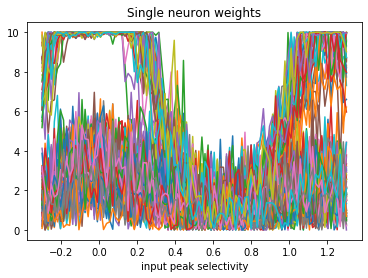

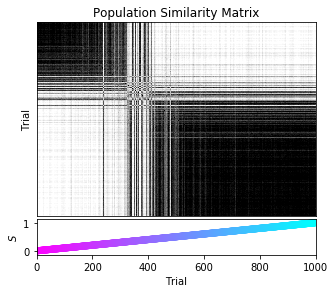

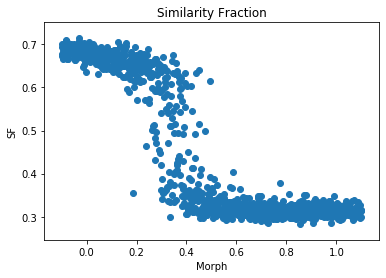

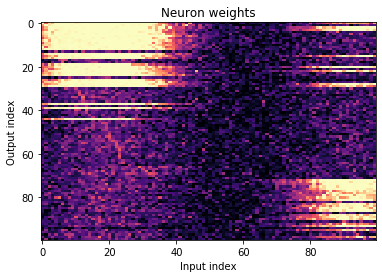

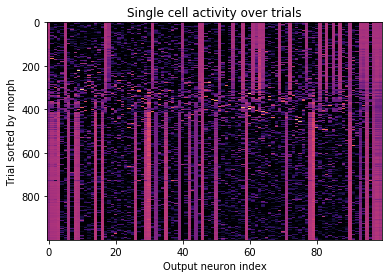

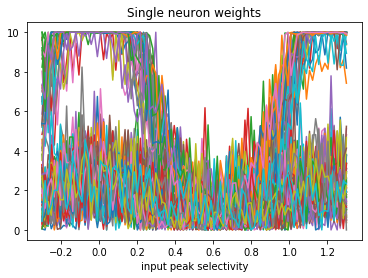

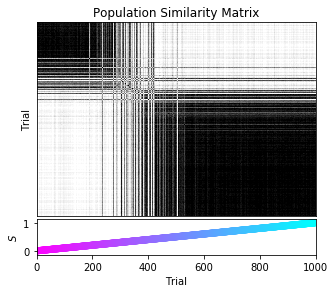

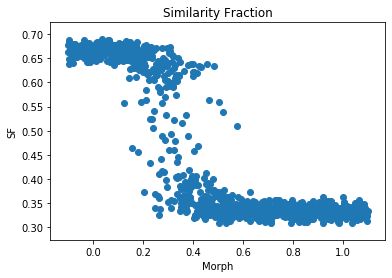

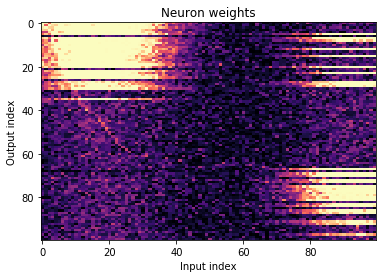

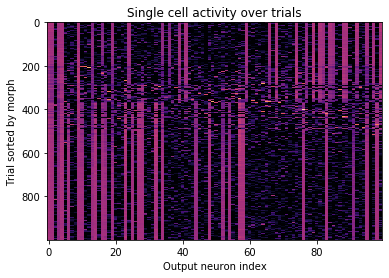

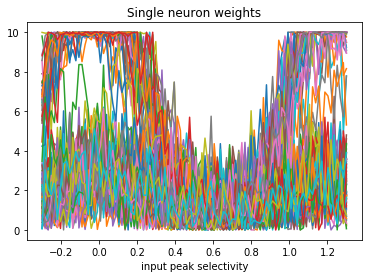

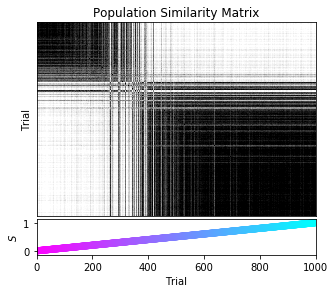

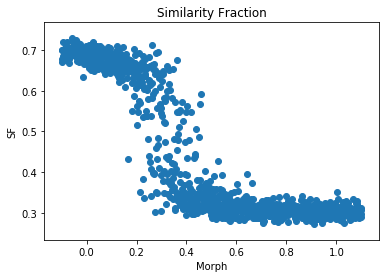

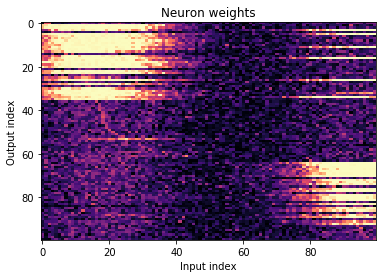

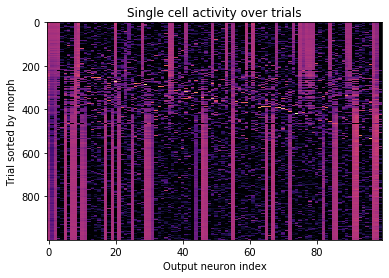

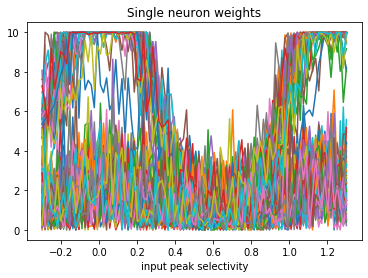

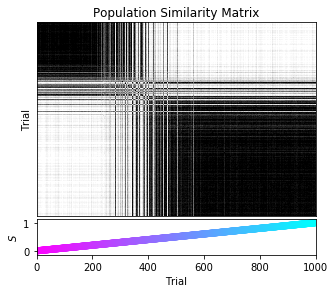

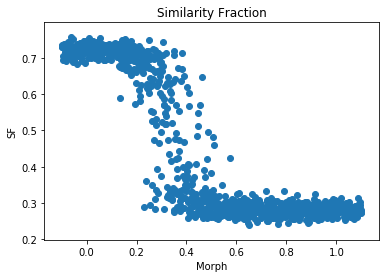

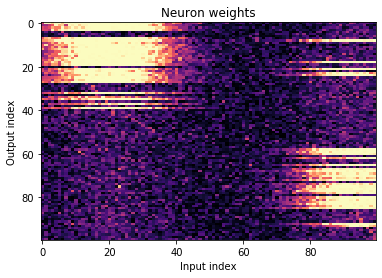

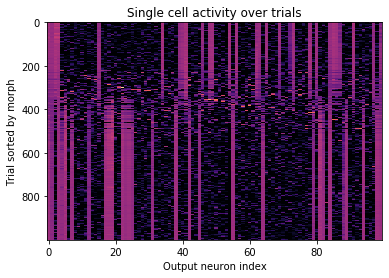

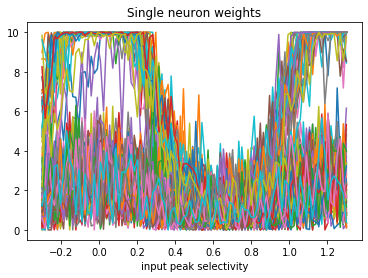

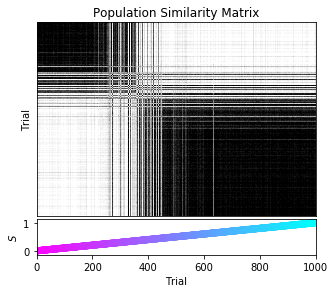

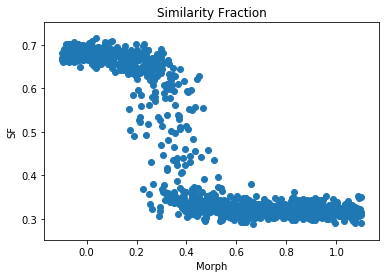

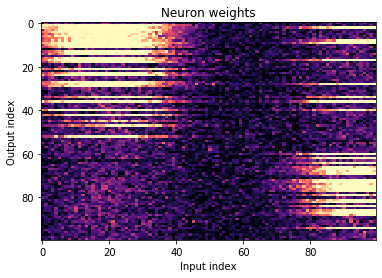

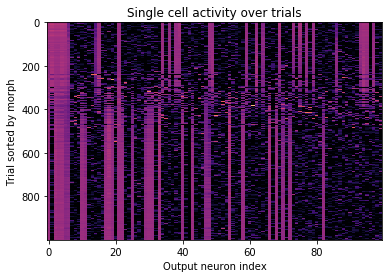

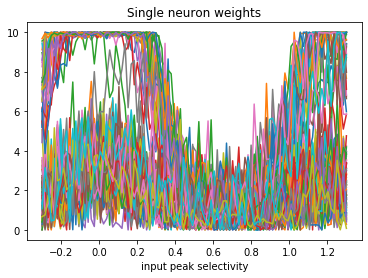

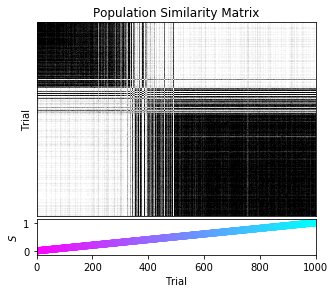

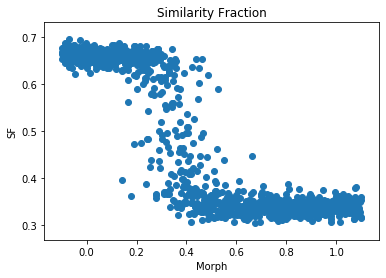

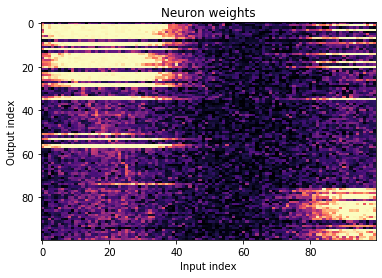

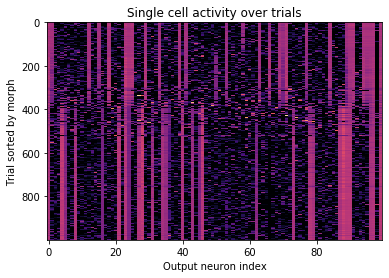

In [16]:
n_models=50
SS_rare,SF_rare = loop_model_instances(rare_spline,d_def,num=n_models)

0


C:\Users\markp\anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\markp\anaconda3\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\markp\anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_op

10
20
30
40


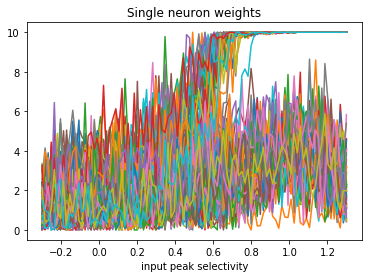

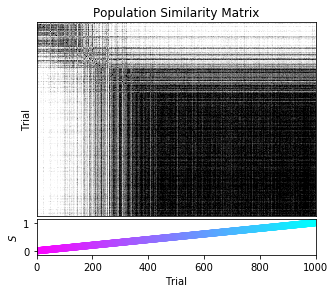

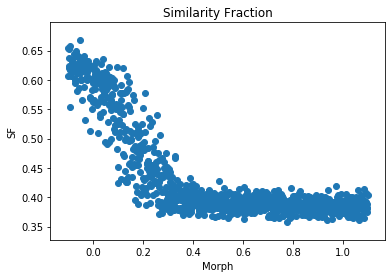

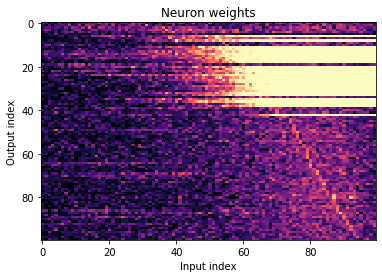

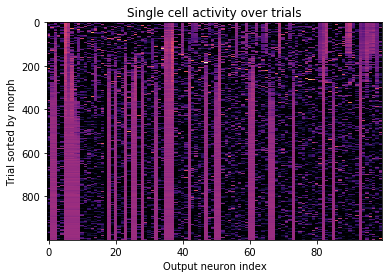

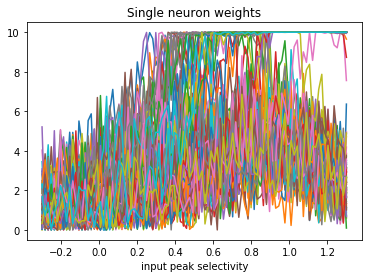

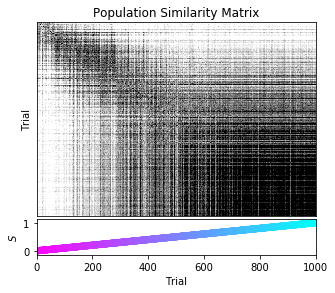

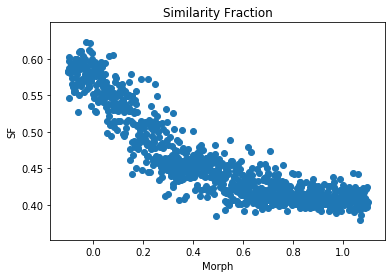

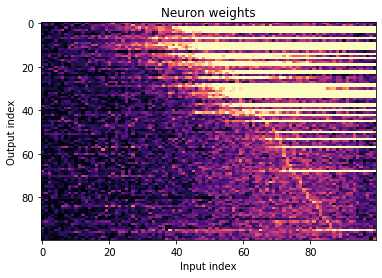

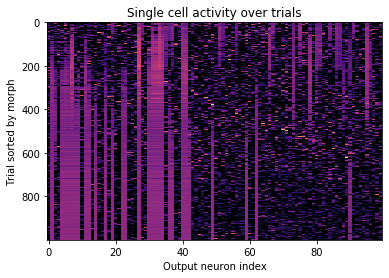

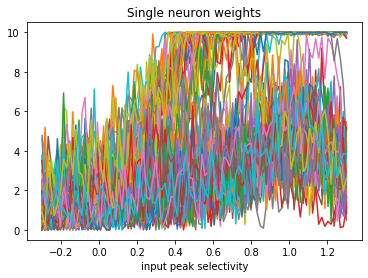

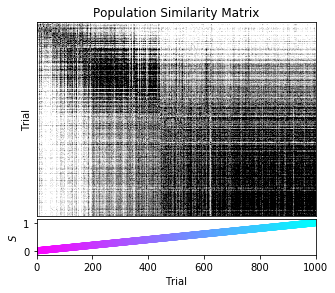

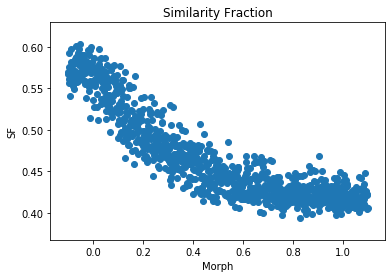

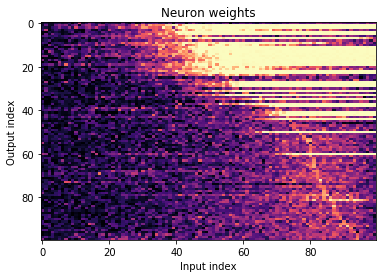

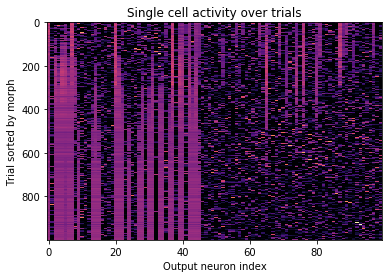

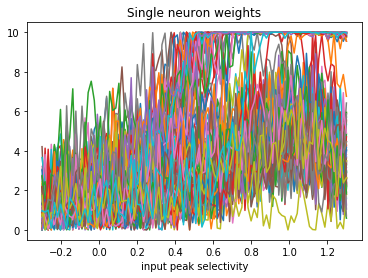

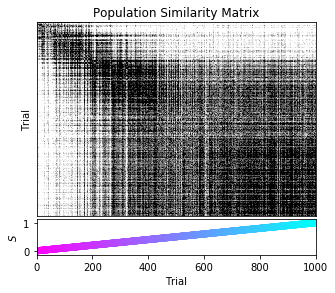

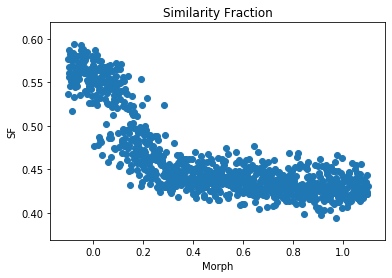

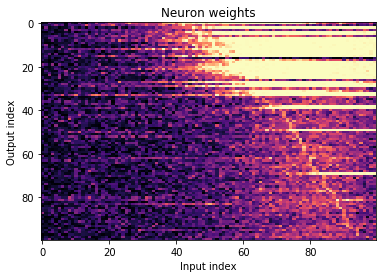

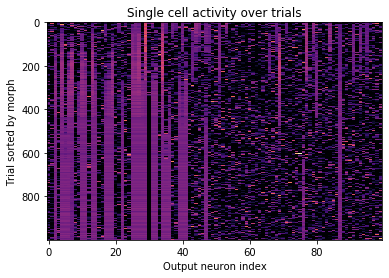

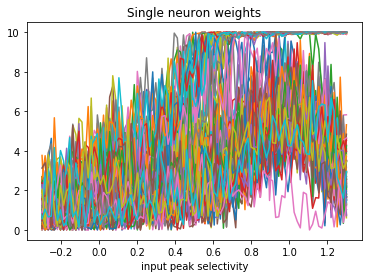

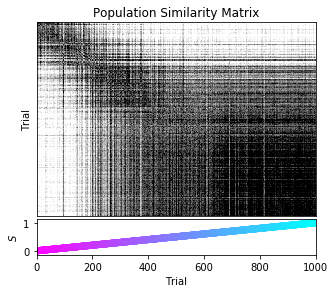

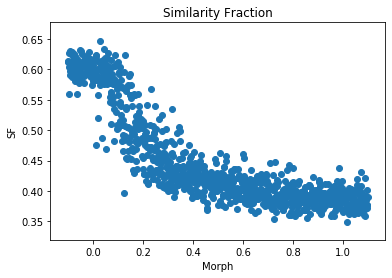

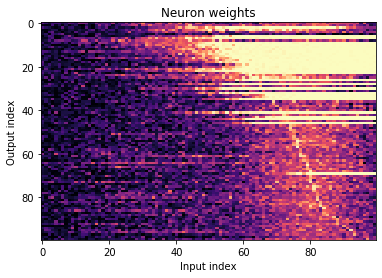

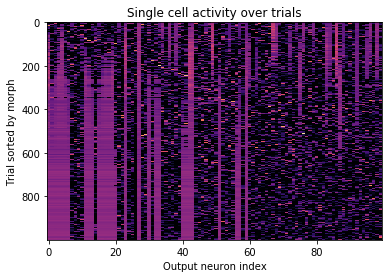

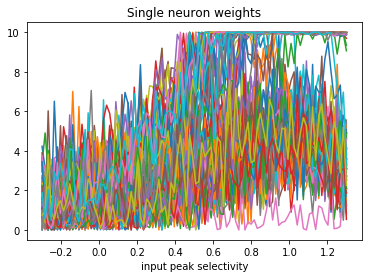

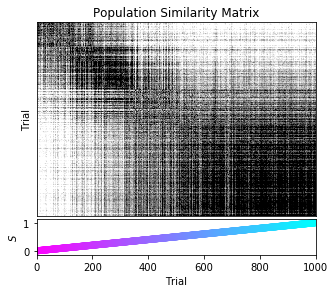

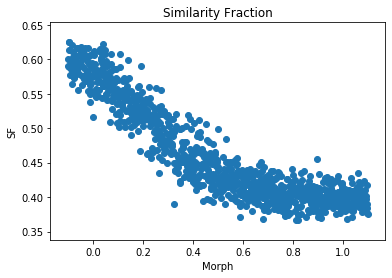

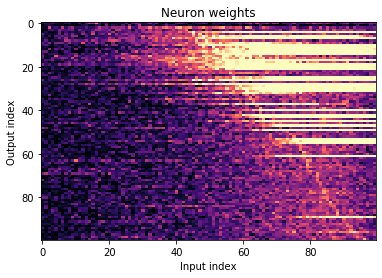

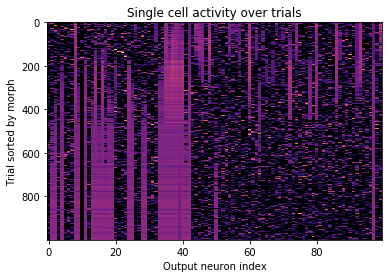

In [17]:
SS_freq,SF_freq = loop_model_instances(freq_spline,d_def,num=n_models)

In [18]:
print(SS_freq.shape,SF_freq.shape)


(50, 1000, 1000) (50, 1000, 1)


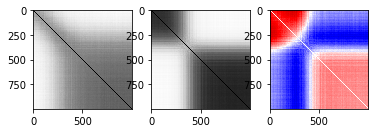

In [24]:
f,ax = plt.subplots(1,3)
ax[0].imshow(SS_freq.mean(axis=0),cmap='Greys')
ax[1].imshow(SS_rare.mean(axis=0),cmap='Greys')
ax[2].imshow(SS_rare.mean(axis=0)-SS_freq.mean(axis=0),cmap='seismic',vmin=-.4,vmax=.4)

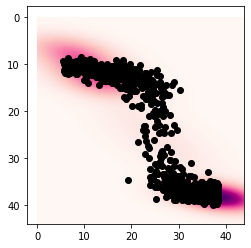

In [57]:
morph_theta = np.linspace(-.1,1.1,num=1000)
mask0 = (morph_theta<=.1) & (morph_theta>=-.1)
mask1 = (morph_theta<=1.1) & (morph_theta>=.9)

f,ax = plt.subplots()
low,high = ut.inv_wallmorphx(-.3), ut.inv_wallmorphx(1.3)
# print(rare_post.shape)
ax.imshow(rare_post.T,cmap='RdPu',extent=[low, high, high, low])
ax.plot(rare_prior)
x = np.linspace(-.3,1.3,num=1000)
HH = 0
wmsm = u.gaussian(morph_theta[:,np.newaxis,np.newaxis],.1,x[np.newaxis,:,np.newaxis])
for it in range(1): 
    sf = SF_rare[it,:]
    rare_yhat = ut.inv_wallmorphx((sf- np.median(sf[mask0]))/(np.median(sf[mask1])-np.median(sf[mask0]))*(1.073-.094) +.094) #(38.051-10.537) + 10.537 #
    ax.scatter(ut.xfreq(morph_theta),rare_yhat,color=plt.cm.copper(np.float(it)/10.))
#     ax.scatter(ut.xfreq(morph_theta))
# ax.set_ylim([1.3,-.3])
#     _sf = SF_rare[0,:]
#     yhsm = u.gaussian(SF_rare[it,:].reshape(-1,1,1),.1,x[np.newaxis,np.newaxis,:])
#     H = np.sum(wmsm*yhsm,axis=0)
#     Z=H.sum(axis=1)
#     H/=H.sum(axis=1,keepdims=True)
#     HH += H

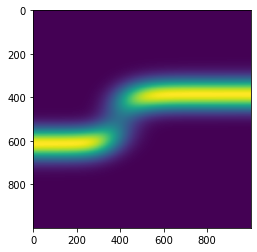

In [32]:
f,ax = plt.subplots()
ax.imshow(HH.T)